## Import Libraries
Import necessary libraries for data processing, model building, and visualization (os, re, random, numpy, tensorflow, keras, scikit-learn, matplotlib, seaborn).

In [57]:
import os
import re
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Set Hyperparameters and Filenames
Define the hyperparameters of the dataset, including phonemes and classes. Load the training data and parse the filenames.

In [58]:
PHONEMES = ['_', 'p', 'b', 't', 'd', 'k', 'g', 'f', 'v', 's', 'z', 'm', 'i', 'ē', 'e', 'a', 'u', 'oo', 'ū', 'a(r)', 'ā', 'ī', 'oy']
CLASSES = len(PHONEMES)

def get_files_with_prefix(directory, prefix):
    files = os.listdir(directory)
    filtered_files = [file for file in files if file.startswith(prefix)]
    return filtered_files

directory = "/content"
X_filename = get_files_with_prefix(directory, f"X_first22")[0]
y_filename = get_files_with_prefix(directory, f"y_first22")[0]

print(f"X_filename: {X_filename}")
print(f"y_filename: {y_filename}")

X_filename: X_first22_2242_3_10_10.npy
y_filename: y_first22_2242_3_10_10.npy


## Parse Filename

In [59]:
def parse_filename(filename):
    # Regular expression pattern to extract the required information from the filename
    pattern = r"X_first22_(\d+)_(\d+)_(\d+)_\d+.npy"

    # Use regular expression to search and extract the required information
    match = re.search(pattern, filename)

    if match:
        num_examples = int(match.group(1))
        channels = int(match.group(2))
        size = int(match.group(3))

        return num_examples, channels, size
    else:
        raise ValueError("Invalid filename format")

NUM_EXAMPLES, CHANNELS, SIZE = parse_filename(X_filename)

print("NUM_EXAMPLES:", NUM_EXAMPLES)
print("channels:", CHANNELS)
print("size:", SIZE)

NUM_EXAMPLES: 2242
channels: 3
size: 10


## Train/Test Split

In [60]:
# Load the training data
X_train_og = np.load(X_filename)
y_train_og = np.load(y_filename)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_train_og, y_train_og, test_size=0.2, random_state=42)

# Prepare the data - N training examples, 4 channels (muscle groups) per example, each 100 timesteps long
X_train = X_train.reshape(-1, CHANNELS, SIZE)
X_test = X_test.reshape(-1, CHANNELS, SIZE)

print(f"X_train.shape: {X_train.shape} - {X_train.shape[0]} training examples")
print(f"X_test.shape: {X_test.shape} - {X_test.shape[0]} testing examples")

X_train.shape: (1793, 3, 10) - 1793 training examples
X_test.shape: (449, 3, 10) - 449 testing examples


## Original/Training/Test Set Distributions
Uncomment for more info about training example distrubtions across phonemes/classes.

In [61]:
# UNCOMMENT FOR SET DISTRIBUTIONS

# # Count the occurrences of each class in the training set
# y_og_counts = Counter(y_train_og)

# # Count the occurrences of each class in the training set
# y_train_counts = Counter(y_train)

# # Count the occurrences of each class in the test set
# y_test_counts = Counter(y_test)

# Print the occurrences
# print("Occurrences in the original set:")
# for phoneme_index, count in sorted(y_og_counts.items()):
#     print(f"\tPhoneme {PHONEMES[phoneme_index]}: {count}")

# print("Occurrences in the training set:")
# for phoneme_index, count in sorted(y_train_counts.items()):
#     print(f"\tPhoneme {PHONEMES[phoneme_index]}: {count}")

# print("Occurrences in the test set:")
# for phoneme_index, count in sorted(y_test_counts.items()):
#     print(f"\tPhoneme {PHONEMES[phoneme_index]}: {count}")

## Define the Model
Create a sequential model using various layers such as Conv1D, Dropout, LSTM, and Dense, then compile the model with loss, optimizer, and metrics.

In [62]:
# Define the model
model = tf.keras.Sequential([
    layers.Conv1D(128, 3, activation='relu', input_shape=(CHANNELS, SIZE), padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Conv1D(256, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.LSTM(128, kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(CLASSES, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 3, 128)            3968      
                                                                 
 batch_normalization_8 (Batc  (None, 3, 128)           512       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 3, 128)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 2, 256)            98560     
                                                                 
 batch_normalization_9 (Batc  (None, 2, 256)           1024      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 2, 256)           

## Define Early Stopping callback
Define an EarlyStopping callback function to prevent overfitting.

In [63]:
# Define Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=200,
    mode='max',
    restore_best_weights=True
)

## Train the Model
Fit the model on the training data and validate it on the testing data using the early stopping callback.

In [64]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=1000,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[callback]
)

Epoch 1/1000
29/29 [==============================] - 7s 67ms/step - loss: 3.3768 - accuracy: 0.1076 - val_loss: 3.2066 - val_accuracy: 0.0312
Epoch 2/1000
29/29 [==============================] - 1s 49ms/step - loss: 2.4291 - accuracy: 0.2588 - val_loss: 3.1826 - val_accuracy: 0.0735
Epoch 3/1000
29/29 [==============================] - 2s 63ms/step - loss: 1.8857 - accuracy: 0.3553 - val_loss: 3.1436 - val_accuracy: 0.0423
Epoch 4/1000
29/29 [==============================] - 2s 50ms/step - loss: 1.5227 - accuracy: 0.4501 - val_loss: 3.1361 - val_accuracy: 0.0445
Epoch 5/1000
29/29 [==============================] - 1s 41ms/step - loss: 1.3272 - accuracy: 0.5014 - val_loss: 3.1630 - val_accuracy: 0.0423
Epoch 6/1000
29/29 [==============================] - 1s 38ms/step - loss: 1.2385 - accuracy: 0.5254 - val_loss: 3.2367 - val_accuracy: 0.0423
Epoch 7/1000
29/29 [==============================] - 1s 40ms/step - loss: 1.1454 - accuracy: 0.5795 - val_loss: 3.4395 - val_accuracy: 0.0423

## Evaluate the Model

In [69]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)


print(f"Test Example Count: {len(y_test)}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Correctness: {int(np.round(test_accuracy * len(y_test)))} / {len(y_test)}")

Test Example Count: 449
Test Loss: 0.18518821895122528
Test Accuracy: 0.9710467457771301
Test Correctness: 436 / 449


## Plotting Training and Validation Loss and Accuracy
Create plots for training and validation loss, as well as training and validation accuracy.

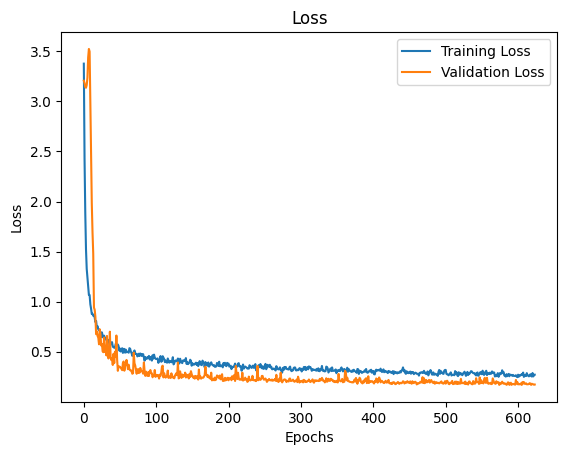

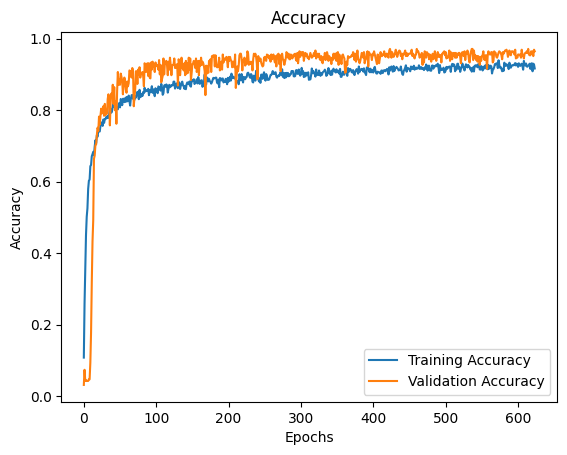

In [70]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Calculate and Display Confusion Matrix
Get the predicted classes for the entire test set, then create and display the confusion matrix using a heatmap.

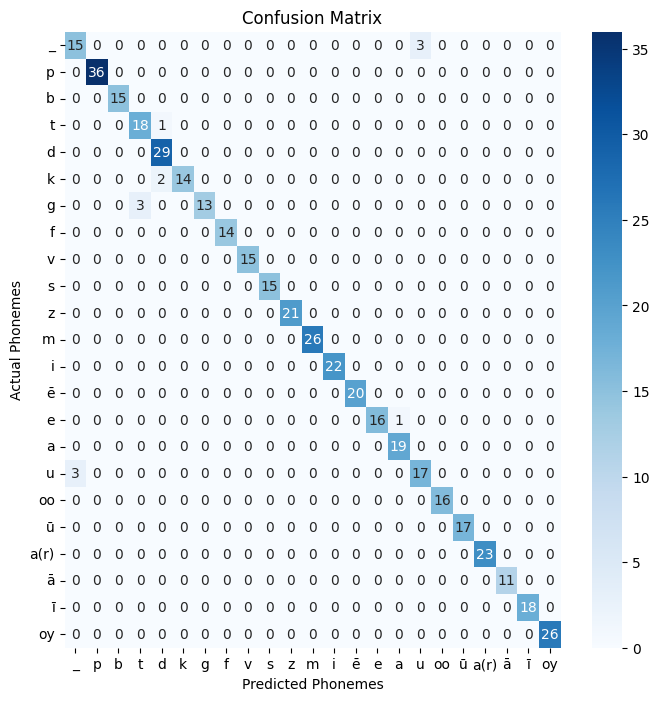

In [71]:
# Get the predicted classes for the entire test set
y_predicted = model.predict(X_test, verbose=0)
y_predicted_classes = np.argmax(y_predicted, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_predicted_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(
                      cm,
                      annot=True,
                      cmap="Blues",
                      fmt='d',  # <- Set integer format for the annotations
                      xticklabels=[PHONEMES[i] for i in range(CLASSES)],
                      yticklabels=[PHONEMES[i] for i in range(CLASSES)],
)

# Modify the rotation of the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Phonemes")
plt.ylabel("Actual Phonemes")
plt.show()

## Test Model on Random Examples
Choose some random examples from the test set and display their actual and predicted phonemes.

In [72]:
# Choose 10 random examples from the test set
random_indices = random.sample(range(X_test.shape[0]), 10)
random_X = X_test[random_indices]
random_y_actual = y_test[random_indices]

# Predict the phoneme using the model
predictions = model.predict(random_X, verbose=0)
random_y_predicted = np.argmax(predictions, axis=1)

# Show actual and predicted phoneme for each picked example
for i in range(10):
    print(f"Example {i + 1}:")
    print(f"\tActual Phoneme: {PHONEMES[random_y_actual[i]]}")
    print(f"\tPredicted Phoneme: {PHONEMES[random_y_predicted[i]]}")

Example 1:
	Actual Phoneme: oo
	Predicted Phoneme: oo
Example 2:
	Actual Phoneme: a(r)
	Predicted Phoneme: a(r)
Example 3:
	Actual Phoneme: i
	Predicted Phoneme: i
Example 4:
	Actual Phoneme: ī
	Predicted Phoneme: ī
Example 5:
	Actual Phoneme: p
	Predicted Phoneme: p
Example 6:
	Actual Phoneme: ū
	Predicted Phoneme: ū
Example 7:
	Actual Phoneme: z
	Predicted Phoneme: z
Example 8:
	Actual Phoneme: d
	Predicted Phoneme: d
Example 9:
	Actual Phoneme: z
	Predicted Phoneme: z
Example 10:
	Actual Phoneme: u
	Predicted Phoneme: u
